<a href="https://colab.research.google.com/github/matthewAlesianiStudent/dtm-big-data-lab/blob/main/Streaming_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reservoir sampling

In [1]:
!pip install Faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.8 MB/s eta 0:00:00


In [2]:
from faker import Faker
import random
Faker.seed(0)
fake = Faker()

reservoir = []
reservoir_size = 15
items_count = 0

def generate_country():
  return 'Italy' if random.random() < 0.5 else fake.country()

def add_to_reservoir(item, print_all=True):
  global reservoir, reservoir_size, items_count
  items_count += 1
  if len(reservoir) < reservoir_size:
    reservoir.append(item)
    if print_all:
      print(f"{items_count}: item {item} added to reservoir because space was available")
    return 1
  else:
    p = random.random()
    if p <= reservoir_size / items_count:
      ix_of_item_to_replace = random.randint(0, reservoir_size - 1)
      item_to_replace = reservoir[ix_of_item_to_replace]
      reservoir[ix_of_item_to_replace] = item
      if print_all:
        print(f"{items_count}, p: {p}, threshold: {reservoir_size / items_count}; item {item_to_replace} in position {ix_of_item_to_replace} replaced with {item}")
      return 1
    else:
      if print_all:
        print(f"{items_count}, p: {p}, threshold: {reservoir_size / items_count}; item {item} not added")
      return 0

In [20]:
add_to_reservoir(generate_country())
print(f"Reservoir: {reservoir}")

10017, p: 0.6408470743296214, threshold: 0.001497454327643007; item Bermuda not added
Reservoir: ['Italy', 'Italy', 'Italy', 'Italy', 'Iceland', 'Samoa', 'Italy', 'Italy', 'Italy', 'Italy', 'Namibia', 'Svalbard & Jan Mayen Islands', 'Italy', 'Italy', 'Italy']


In [19]:
subs = 0
for _ in range(10000):
  subs += add_to_reservoir(generate_country(),False)
print(f"Reservoir: {reservoir}\nSubstitutions: {subs}")

Reservoir: ['Italy', 'Italy', 'Italy', 'Italy', 'Iceland', 'Samoa', 'Italy', 'Italy', 'Italy', 'Italy', 'Namibia', 'Svalbard & Jan Mayen Islands', 'Italy', 'Italy', 'Italy']
Substitutions: 104


# HyperLogLog

In [21]:
import math
import numpy as np
import matplotlib.pyplot as plt

def random_hashes(n, bits=32):
    """Generate n random integers uniformly in [0, 2^bits)."""
    return np.random.randint(0, 2**bits, size=n, dtype=np.uint64)

def leading_zeros(x, bits=32):
    """Count leading zeros in the binary representation of x."""
    xi = int(x)  # convert numpy.uint64 → Python int
    if xi == 0:
        return bits
    return bits - xi.bit_length()

def trailing_zeros(x):
    """Count trailing zeros (CTZ)."""
    xi = int(x)
    if xi == 0:
        return 64  # arbitrary large number
    return (xi & -xi).bit_length() - 1

v_leading_zeros = np.vectorize(leading_zeros)
v_trailing_zeros = np.vectorize(trailing_zeros)


In [22]:
n = 10
hs = random_hashes(n)
max_lead = v_leading_zeros(hs).max()
max_trail = v_trailing_zeros(hs).max()

print(f"Max lead: {max_lead} (est: {2**max_lead}); Max trail: {max_trail} (est: {2**max_trail}); Real: {n}")

for h in hs:
  print(f"Hash: {bin(h)} Leading zeros: {leading_zeros(h)} Trailing zeros: {trailing_zeros(h)}")

Max lead: 5 (est: 32); Max trail: 4 (est: 16); Real: 10
Hash: 0b1001110000111000110000100000111 Leading zeros: 1 Trailing zeros: 0
Hash: 0b11100010111000011110010010000010 Leading zeros: 0 Trailing zeros: 1
Hash: 0b110011001110010010010101011 Leading zeros: 5 Trailing zeros: 0
Hash: 0b11001010010010111101101010110 Leading zeros: 3 Trailing zeros: 1
Hash: 0b1000000100011110110001010010011 Leading zeros: 1 Trailing zeros: 0
Hash: 0b1010001101111101110000111010000 Leading zeros: 1 Trailing zeros: 4
Hash: 0b1110010101110000000100111001010 Leading zeros: 1 Trailing zeros: 1
Hash: 0b1100001110111010001110110010111 Leading zeros: 1 Trailing zeros: 0
Hash: 0b1110011100101000010000001110110 Leading zeros: 1 Trailing zeros: 1
Hash: 0b1110111010000111100111101111110 Leading zeros: 1 Trailing zeros: 1


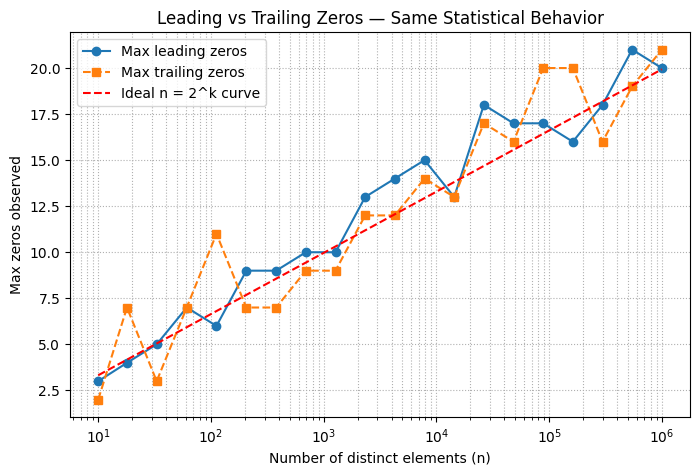

In [23]:
def experiment(n_values):
    """Return average max-zeros for both methods as n grows."""
    leading_results = []
    trailing_results = []

    for n in n_values:
        h = random_hashes(n)
        max_lead = v_leading_zeros(h).max()
        max_trail = v_trailing_zeros(h).max()
        leading_results.append(max_lead)
        trailing_results.append(max_trail)

    return np.array(leading_results), np.array(trailing_results)

# Try various stream sizes
n_values = np.logspace(1, 6, num=20, dtype=int)
lead, trail = experiment(n_values)
ideal = [math.log2(x) for x in n_values]

plt.figure(figsize=(8,5))
plt.plot(n_values, lead, 'o-', label='Max leading zeros')
plt.plot(n_values, trail, 's--', label='Max trailing zeros')
plt.plot(n_values, ideal, 'r--', label='Ideal n = 2^k curve')
plt.xscale('log')
plt.xlabel("Number of distinct elements (n)")
plt.ylabel("Max zeros observed")
plt.title("Leading vs Trailing Zeros — Same Statistical Behavior")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.show()

# Bloom filter

In [24]:
import hashlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

from faker import Faker
Faker.seed(0)
fake = Faker()

class SimpleBloomFilter:
    def __init__(self, size=50, hash_count=3):
        self.size = size                # number of bits
        self.hash_count = hash_count    # number of hash functions
        self.bits = [0] * size          # bit array

    def _hashes(self, item):
        """Generate several hash indices for the item."""
        return [
            int(hashlib.md5((item + str(i)).encode()).hexdigest(), 16) % self.size
            for i in range(self.hash_count)
        ]

    def add(self, item):
        """Add item to filter."""
        for index in self._hashes(item):
            self.bits[index] = 1

    def contains(self, item):
        """Check if item might be in the set."""
        return all(self.bits[i] == 1 for i in self._hashes(item))

    def visualize(self, it):
        """Show bit array as a visual grid."""
        plt.figure(figsize=(10, 1))
        b = [b for b in self.bits]
        for i in self._hashes(it):
          if b[i]==1:
            b[i]=2
          else:
            b[i]=-1
        color_map = {
          2: 'blue',  # It's a hit
          1: 'green',
          -1: 'red'   # It's a miss
        }
        c = [color_map.get(x, 'white') for x in b]
        rgb = np.array([mcolors.to_rgb(color) for color in c]).reshape(1, -1, 3)
        plt.imshow(rgb, aspect='auto')
        plt.title(f"Checking {it}")
        plt.yticks([])
        plt.xticks(range(self.size))
        plt.show()


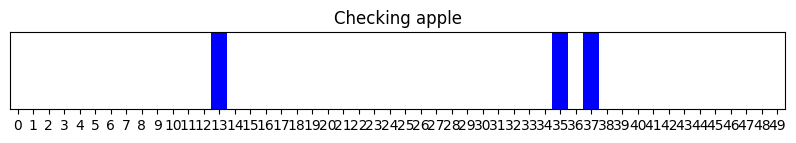

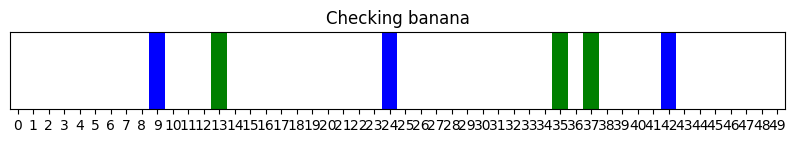

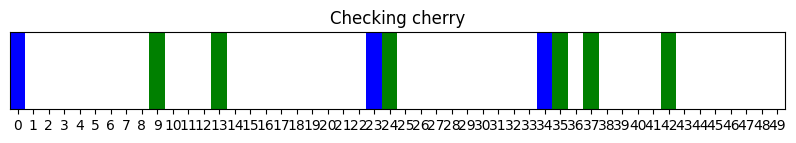

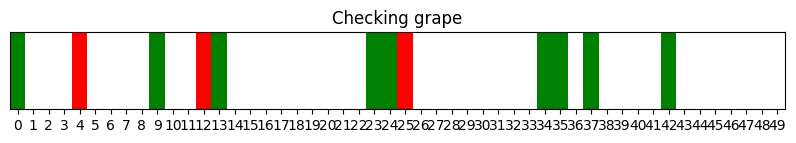

In [32]:
bloom = SimpleBloomFilter(size=50, hash_count=3)

items = ["apple", "banana", "cherry"]
for item in items:
    bloom.add(item)
    bloom.visualize(item)

bloom.visualize('grape')

In [30]:
bloom.add('pluto')

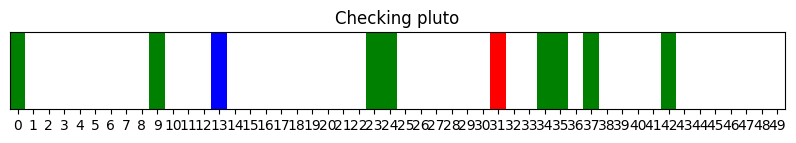

In [31]:
bloom.visualize('pluto')

# CountMin Sketch

In [33]:
import hashlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

from faker import Faker
Faker.seed(0)
fake = Faker()

class CountMinSketch:
    def __init__(self, width=30, depth=4):
        self.width = width     # number of columns
        self.depth = depth     # number of hash functions / rows
        self.table = np.zeros((depth, width), dtype=int)

    def _hashes(self, item):
        """Generate several hash indices for the item."""
        return [
            int(hashlib.md5((item + str(i)).encode()).hexdigest(), 16) % self.width
            for i in range(self.depth)
        ]

    def add(self, item, count=1):
        """Add item with count."""
        indices = self._hashes(item)
        for d, col in enumerate(indices):
            self.table[d, col] += count

    def estimate(self, item):
        """Estimate count of an item."""
        indices = self._hashes(item)
        return min(self.table[d, col] for d, col in enumerate(indices))

    def visualize(self, item, adding=False):
        """Visualize the table, highlighting the columns used by 'item'."""
        indices = self._hashes(item)
        data = self.table.copy()

        # Highlight the relevant columns
        highlight = np.zeros_like(data)
        for d, col in enumerate(indices):
            highlight[d, col] = 1

        plt.figure(figsize=(12, 3))
        plt.imshow(data, cmap="Greens", aspect='auto')
        plt.title(f"{'Adding' if adding else 'Querying'} '{item}' (estimate={self.estimate(item)})")
        plt.xlabel("Columns (hash buckets)")
        plt.ylabel("Hash functions")

        # Overlay red highlights
        for d, col in enumerate(indices):
            plt.gca().add_patch(plt.Rectangle((col-0.5, d-0.5), 1, 1,
                                              edgecolor='red', facecolor='none', lw=2))

        plt.colorbar(label="Count")
        plt.show()


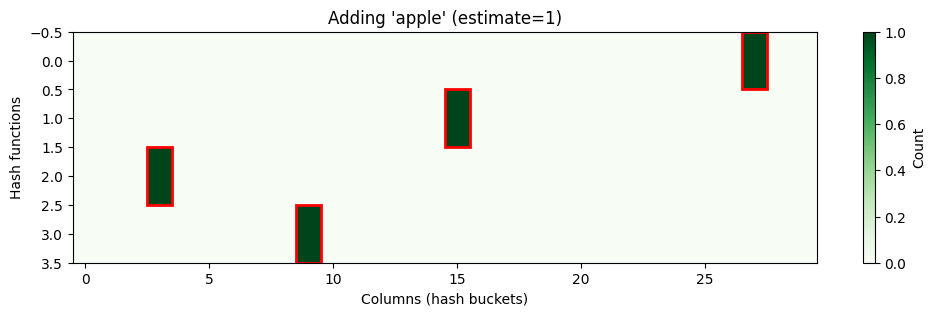

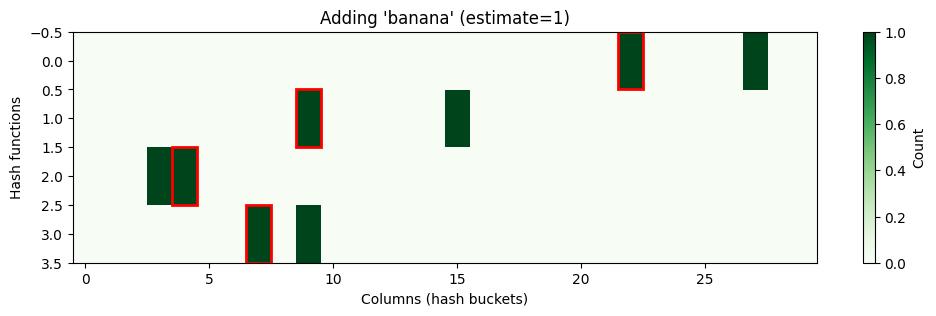

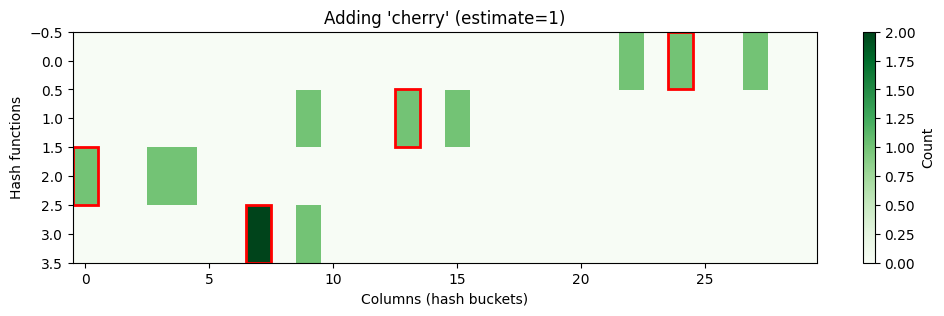

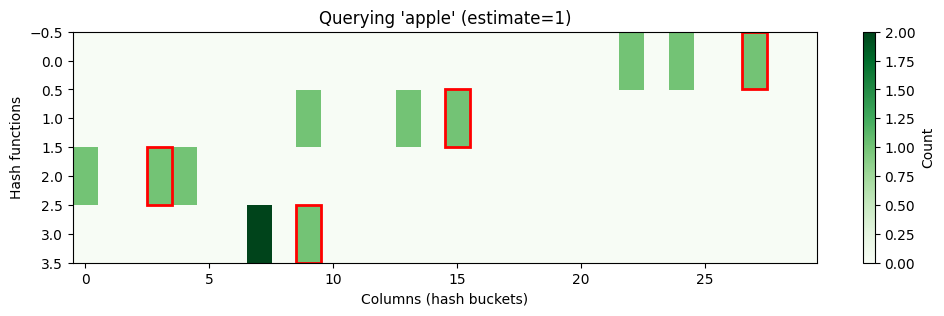

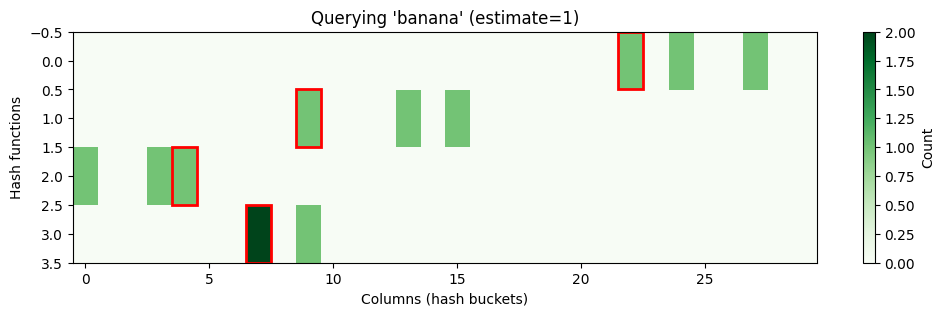

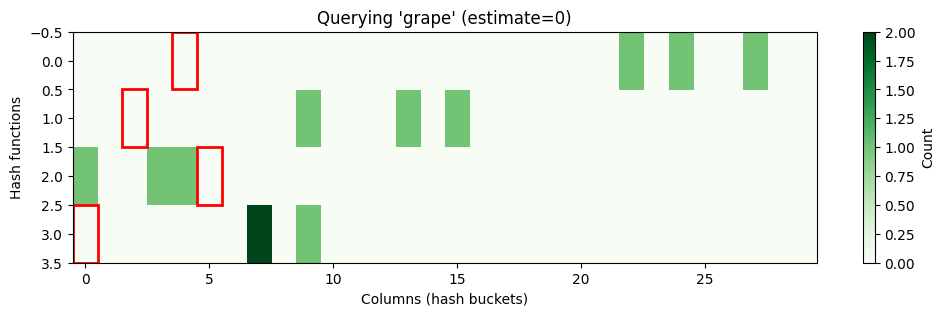

In [34]:
cms = CountMinSketch(width=30, depth=4)

items = ["apple", "banana", "cherry"]

for item in items:
    cms.add(item)
    cms.visualize(item, adding=True)

# Query existing and unseen items
for test_item in ["apple", "banana", "grape"]:
    cms.visualize(test_item, adding=False)

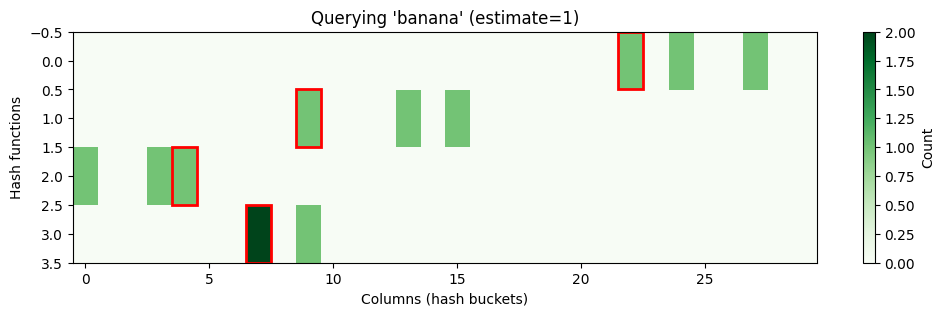

In [35]:
item = 'banana'
# cms.add(item)
cms.visualize(item, adding=False)